In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install folium


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하차총승객수)

In [2]:
# 1. 필요한 라이브러리 불러오기

import collections
import datetime
import glob
import math
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium


pd.options.display.float_format = '{:,}'.format

plt.rcParams['font.family'] ='D2Coding'
plt.rcParams['axes.unicode_minus'] =False

DAY_OF_WEEK = ['월', '화', '수', '목', '금', '토', '일']

In [3]:
# 2. 현재 사용가능한 데이터 확인

DIRNAME = 'rawfiles'

os.listdir(DIRNAME)

['CARD_SUBWAY_MONTH_201903.csv',
 'CARD_SUBWAY_MONTH_201902.csv',
 'CARD_SUBWAY_MONTH_201901.csv',
 'CARD_SUBWAY_MONTH_201905.csv',
 'CARD_SUBWAY_MONTH_201904.csv',
 'CARD_SUBWAY_MONTH_201906.csv',
 '지하철노선위경도정보2.csv']

In [4]:
df_location_raw = pd.read_csv(os.path.join(DIRNAME, '지하철노선위경도정보2.csv'))

In [5]:
# 3. 데이터를 병합하여 하나의 데이터프레임 형성

df_subway_raw = pd.DataFrame()

for filename in glob.glob(os.path.join(DIRNAME, 'CARD_SUBWAY_MONTH_*.csv')):
    tmp = pd.read_csv(filename)
    df_subway_raw = pd.concat([df_subway_raw, tmp])

In [6]:
df_subway_raw.sample(5)

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
8674,20190415,5호선,서대문,"22,728.0","23,442.0",20190418
9338,20190116,7호선,먹골,"11,762.0","11,489.0",20190119
8136,20190114,6호선,보문,"7,943.0","7,246.0",20190117
14793,20190226,2호선,잠실나루,"20,958.0","20,488.0",20190301
7828,20190314,1호선,독산,"20,064.0","21,215.0",20190317


In [7]:
df_subway_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107028 entries, 0 to 17723
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   사용일자    107028 non-null  int64  
 1   노선명     107028 non-null  object 
 2   역명      107028 non-null  object 
 3   승차총승객수  107028 non-null  float64
 4   하차총승객수  107028 non-null  float64
 5   등록일자    107028 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


In [8]:
# dt.dayofweek로 표현된 요일의 번호가 0~6까지 각각 월~일에 대응되는지 확인해보자.

df = df_subway_raw.copy()

df['사용일자'] = pd.to_datetime(df['사용일자'], format='%Y%m%d')
df['요일'] = df['사용일자'].dt.dayofweek

# 달력을 통해, 2019년 5월 5일 어린이날은 '일요일'인 것을 알고있는 상황.
# 2019년도 어린이 날에 해당하는 데이터만 필터링한다.
df = df[df['사용일자'] == '2019-05-05']

# 어린이 날(일요일)의 dayofweek(숫자)를 확인한다.
df.head()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,요일
2370,2019-05-05,4호선,서울역,"45,856.0","42,422.0",20190508,6
2371,2019-05-05,2호선,시청,"15,457.0","15,413.0",20190508,6
2372,2019-05-05,1호선,종각,"31,735.0","27,154.0",20190508,6
2373,2019-05-05,3호선,종로3가,"26,047.0","24,846.0",20190508,6
2374,2019-05-05,1호선,종로5가,"16,105.0","16,292.0",20190508,6


In [9]:
df_subway_raw['사용일자'] = pd.to_datetime(df_subway_raw['사용일자'], format='%Y%m%d')
df_subway_raw['주차'] = df_subway_raw['사용일자'].dt.dayofyear // 7 + 1
df_subway_raw['요일'] = df_subway_raw['사용일자'].dt.dayofweek.map({ idx: val for idx, val in enumerate(DAY_OF_WEEK) })
df_subway_raw['연'] = df_subway_raw['사용일자'].dt.year
df_subway_raw['월'] = df_subway_raw['사용일자'].dt.month
df_subway_raw['일'] = df_subway_raw['사용일자'].dt.date
df_subway_raw['승하차총승객수'] = df_subway_raw['승차총승객수'] + df_subway_raw['하차총승객수']

df_subway_raw.sample(10)

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,주차,요일,연,월,일,승하차총승객수
13163,2019-06-23,1호선,백운,"5,906.0","5,957.0",20190626,25,일,2019,6,2019-06-23,"11,863.0"
12369,2019-03-21,9호선,증미,"8,402.0","8,473.0",20190324,12,목,2019,3,2019-03-21,"16,875.0"
578,2019-04-01,9호선,마곡나루,"6,068.0","5,267.0",20190404,14,월,2019,4,2019-04-01,"11,335.0"
6031,2019-06-11,1호선,신길,"11,738.0","9,802.0",20190614,24,화,2019,6,2019-06-11,"21,540.0"
12033,2019-04-21,1호선,지행,"5,432.0","5,533.0",20190424,16,일,2019,4,2019-04-21,"10,965.0"
12152,2019-04-21,경의선,월롱,"1,092.0","1,928.0",20190424,16,일,2019,4,2019-04-21,"3,020.0"
4453,2019-01-08,경의선,백마,"7,673.0","7,159.0",20190111,2,화,2019,1,2019-01-08,"14,832.0"
5114,2019-03-09,1호선,신길,"2,529.0","2,808.0",20190312,10,토,2019,3,2019-03-09,"5,337.0"
15276,2019-03-26,7호선,반포,"7,624.0","7,409.0",20190329,13,화,2019,3,2019-03-26,"15,033.0"
3223,2019-02-06,2호선,사당,"19,357.0","22,472.0",20190209,6,수,2019,2,2019-02-06,"41,829.0"


# 이제 문제에 답해봅시다.

### 1. 2019.01~06중에 언제 지하철을 가장 많이 이용했을까? (기준:승하차총승객수)

In [10]:
df_subway_raw.groupby('월').sum('승하차총승객수').sort_values('승하차총승객수', ascending=False)

,승차총승객수,하차총승객수,등록일자,주차,연,승하차총승객수
월,,,,,,
5,"243,338,053.0","242,380,504.0",370213478472,366705,37020384,"485,718,557.0"
4,"235,928,571.0","235,005,777.0",358359862392,278074,35835231,"470,934,348.0"
3,"233,813,277.0","232,879,549.0",370330953373,206498,37032498,"466,692,826.0"
1,"221,848,014.0","220,898,375.0",370165764399,52645,37016346,"442,746,389.0"
6,"221,547,039.0","220,663,596.0",357858646377,431295,35784756,"442,210,635.0"
2,"190,335,812.0","189,500,198.0",334006895930,116999,33400317,"379,836,010.0"


### 2. 가설) 1월~6월중에 5월에 지하철 승객수가 많다? (기준:승하차총승객수

In [11]:
df = df_subway_raw.groupby('월') \
    .sum(numeric_only=True) \
    .reset_index() \
    .sort_values('승하차총승객수', ascending=False)

df  # prints the dataframe

,월,승차총승객수,하차총승객수,등록일자,주차,연,승하차총승객수
4,5,"243,338,053.0","242,380,504.0",370213478472,366705,37020384,"485,718,557.0"
3,4,"235,928,571.0","235,005,777.0",358359862392,278074,35835231,"470,934,348.0"
2,3,"233,813,277.0","232,879,549.0",370330953373,206498,37032498,"466,692,826.0"
0,1,"221,848,014.0","220,898,375.0",370165764399,52645,37016346,"442,746,389.0"
5,6,"221,547,039.0","220,663,596.0",357858646377,431295,35784756,"442,210,635.0"
1,2,"190,335,812.0","189,500,198.0",334006895930,116999,33400317,"379,836,010.0"


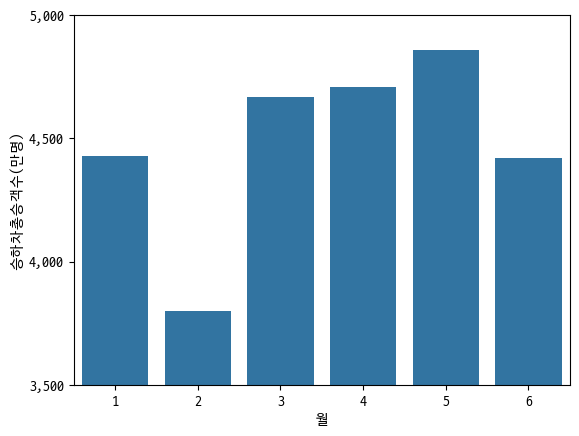

In [12]:
sns.barplot(data=df, x='월', y='승하차총승객수')
plt.ylabel('승하차총승객수(만명)')
plt.ylim(35e7, 50e7)
plt.yticks([35e7, 40e7, 45e7, 50e7], ['3,500', '4,000', '4,500', '5,000'])
plt.show()

In [13]:
row = df.iloc[0]
print(f'{row['월']:.0f}월에 가장 많은 승객수 {row['승하차총승객수']:,.0f}명')

5월에 가장 많은 승객수 485,718,557명


In [14]:
# 혹시 특정 월에 휴일이 몰려있는게 영향이 있을까?

holidays = [
    datetime.date(2019, 1, 1),  # 신정
    datetime.date(2019, 2, 4),  # 설날(연휴)
    datetime.date(2019, 2, 5),  # 설날
    datetime.date(2019, 2, 6),  # 설날(연휴)
    datetime.date(2019, 3, 1),  # 삼일절
    datetime.date(2019, 5, 5),  # 어린이날
    datetime.date(2019, 5, 6),  # (어린이날)대체휴일
    datetime.date(2019, 5, 12),  # 부처님오신날
    datetime.date(2019, 6, 6),  # 현충일
    datetime.date(2019, 8, 15),  # 광복절
    datetime.date(2019, 9, 12),  # 추석(연휴)
    datetime.date(2019, 9, 13),  # 추석
    datetime.date(2019, 9, 14),  # 추석(연휴)
    datetime.date(2019, 10, 3),  # 개천절
    datetime.date(2019, 10, 9),  # 한글날
    datetime.date(2019, 12, 25),  # 크리스마스
]

holidays_per_dayofweek = collections.Counter()
for holiday in holidays:
    holidays_per_dayofweek['월화수목금토일'[holiday.weekday()]] += 1

holidays_per_dayofweek

Counter({'목': 4, '수': 3, '화': 2, '월': 2, '금': 2, '일': 2, '토': 1})

### 3. 가설) 요일중에서 목요일에 지하철 승객수가 많다? (기준:승하차총승객수)

In [15]:
df = df_subway_raw[['요일', '승하차총승객수']] \
    .groupby('요일') \
    .sum(numeric_only=True) \
    .reset_index()
df.sort_values(by='요일', ascending=False).head()

,요일,승하차총승객수
6,화,"411,979,965.0"
5,토,"341,950,018.0"
4,일,"247,523,995.0"
3,월,"391,555,551.0"
2,수,"421,134,136.0"


<Axes: xlabel='요일', ylabel='승하차총승객수'>

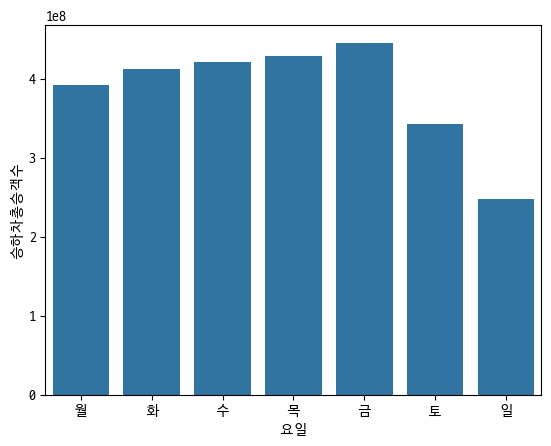

In [16]:
sns.barplot(data=df, x='요일', y='승하차총승객수', order=['월', '화', '수', '목', '금', '토', '일'])

In [17]:
df = df_subway_raw[['요일', '승하차총승객수']] \
    .groupby('요일') \
    .mean(numeric_only=True) \
    .reset_index()
df.sort_values(by='승하차총승객수', ascending=False).head()

,요일,승하차총승객수
0,금,"28,959.531573128697"
1,목,"27,869.222662852684"
2,수,"27,397.966039945353"
6,화,"26,784.99219816657"
3,월,"26,474.344219066938"


<Axes: xlabel='요일', ylabel='승하차총승객수'>

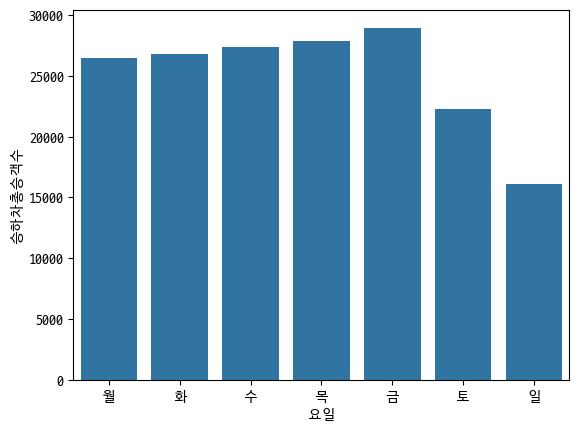

In [18]:
sns.barplot(data=df, x='요일', y='승하차총승객수', order=DAY_OF_WEEK)

In [19]:
df = df_subway_raw[['요일', '승하차총승객수']]
df.sort_values(by='승하차총승객수', ascending=False).head()

,요일,승하차총승객수
5943,금,"270,553.0"
14224,금,"268,590.0"
10085,금,"267,565.0"
8295,금,"265,482.0"
1809,금,"264,826.0"


In [20]:
row = df.sort_values(by='승하차총승객수', ascending=False).iloc[0]
print(f"{row['요일']}요일에 가장 많은 승객수 {row['승하차총승객수']:,.0f}명")

금요일에 가장 많은 승객수 270,553명


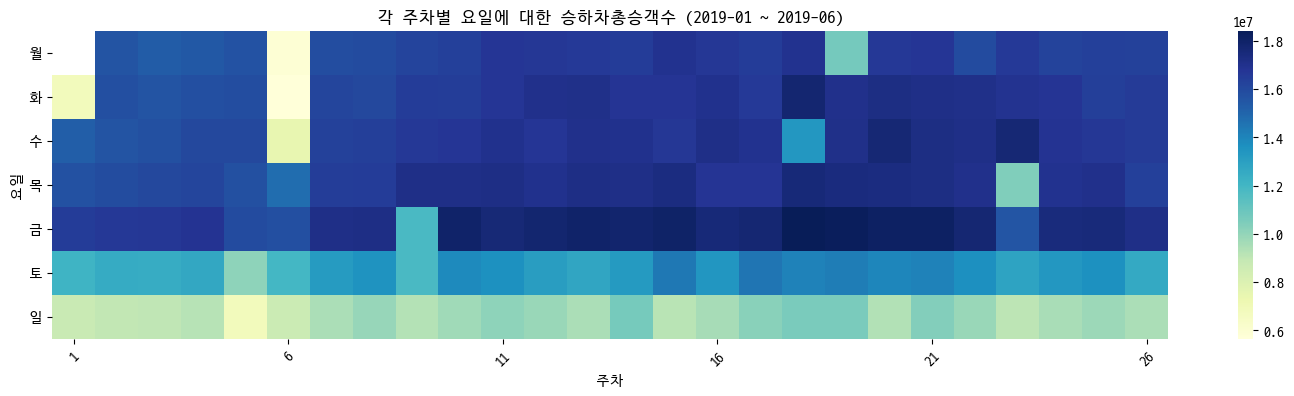

In [21]:
df = df_subway_raw \
    .groupby(['주차', '요일']) \
    .sum(numeric_only=True) \
    .reset_index() \
    .pivot(index='요일', columns='주차', values='승하차총승객수')

df.index = pd.CategoricalIndex(df.index, categories=DAY_OF_WEEK)
df.sort_index(inplace=True)

plt.figure(figsize=(18, 4))
sns.heatmap(df, cmap='YlGnBu')
plt.title("각 주차별 요일에 대한 승하차총승객수 (2019-01 ~ 2019-06)")
plt.yticks(rotation=0)
plt.xticks(plt.xticks()[0][::5], rotation=45)
plt.show()

In [22]:
df = df_subway_raw \
    .groupby(['사용일자', '요일']) \
    .sum(numeric_only=True) \
    .reset_index()

df.index = pd.CategoricalIndex(df.index, categories=DAY_OF_WEEK)
df.sort_index(inplace=True)

df  # prints the dataframe

,사용일자,요일,승차총승객수,하차총승객수,등록일자,주차,연,월,승하차총승객수
NaN,2019-01-01,화,"3,419,948.0","3,393,505.0",11952541568,592,1195248,592,"6,813,453.0"
NaN,2019-01-02,수,"7,621,668.0","7,592,334.0",11952542160,592,1195248,592,"15,214,002.0"
NaN,2019-01-03,목,"7,873,692.0","7,842,521.0",11972732858,593,1197267,593,"15,716,213.0"
NaN,2019-01-04,금,"8,270,345.0","8,238,936.0",11912163130,590,1191210,590,"16,509,281.0"
NaN,2019-01-05,토,"6,062,294.0","6,030,041.0",11891973612,589,1189191,589,"12,092,335.0"
...,...,...,...,...,...,...,...,...,...
NaN,2019-06-26,수,"8,295,254.0","8,266,536.0",11973042997,15418,1197267,3558,"16,561,790.0"
NaN,2019-06-27,목,"8,197,084.0","8,168,560.0",11952852960,15392,1195248,3552,"16,365,644.0"
NaN,2019-06-28,금,"8,599,857.0","8,570,855.0",11932704291,15366,1193229,3546,"17,170,712.0"
NaN,2019-06-29,토,"6,316,617.0","6,284,920.0",11912514180,15340,1191210,3540,"12,601,537.0"


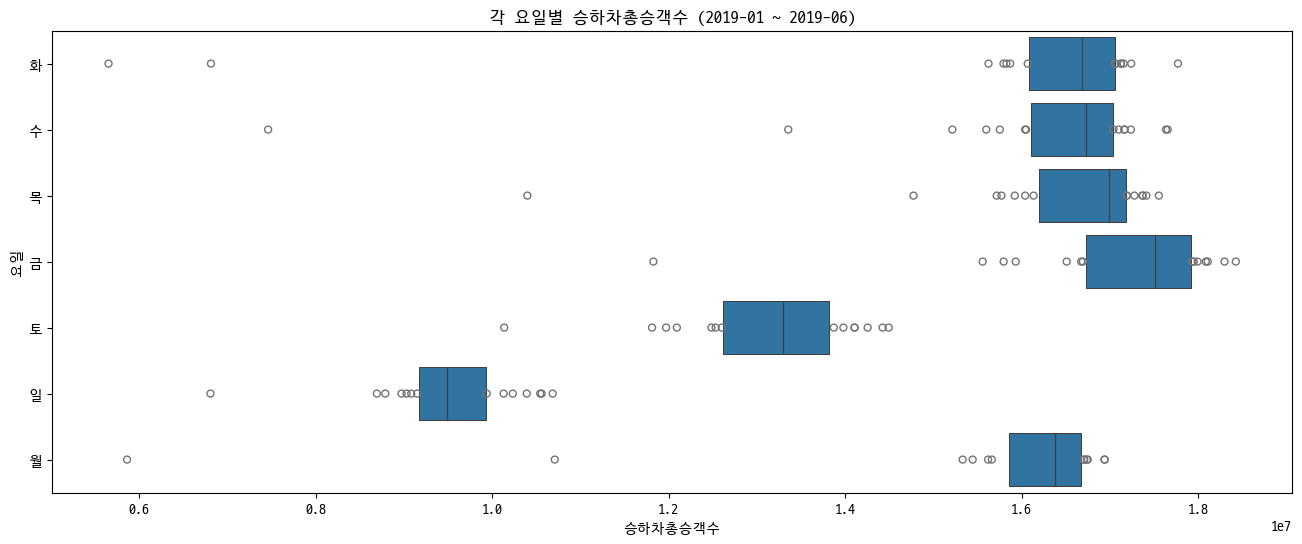

In [23]:
plt.figure(figsize=(16, 6))
sns.boxenplot(data=df, x='승하차총승객수', y='요일')
plt.title("각 요일별 승하차총승객수 (2019-01 ~ 2019-06)")
plt.show()

### 4. 연월 각각에 대해 일자별(월일별) 승하차총승객수 그래프 그려 볼까요? (pointplot)

In [24]:
df = df_subway_raw \
    .groupby('사용일자') \
    .sum(numeric_only=True) \
    .reset_index()
df['월'] = df['사용일자'].dt.month
df['일'] = df['사용일자'].dt.day
df['요일'] = df['사용일자'].dt.dayofweek
df # prints the dataframe

,사용일자,승차총승객수,하차총승객수,등록일자,주차,연,월,승하차총승객수,일,요일
0,2019-01-01,"3,419,948.0","3,393,505.0",11952541568,592,1195248,1,"6,813,453.0",1,1
1,2019-01-02,"7,621,668.0","7,592,334.0",11952542160,592,1195248,1,"15,214,002.0",2,2
2,2019-01-03,"7,873,692.0","7,842,521.0",11972732858,593,1197267,1,"15,716,213.0",3,3
3,2019-01-04,"8,270,345.0","8,238,936.0",11912163130,590,1191210,1,"16,509,281.0",4,4
4,2019-01-05,"6,062,294.0","6,030,041.0",11891973612,589,1189191,1,"12,092,335.0",5,5
...,...,...,...,...,...,...,...,...,...,...
176,2019-06-26,"8,295,254.0","8,266,536.0",11973042997,15418,1197267,6,"16,561,790.0",26,2
177,2019-06-27,"8,197,084.0","8,168,560.0",11952852960,15392,1195248,6,"16,365,644.0",27,3
178,2019-06-28,"8,599,857.0","8,570,855.0",11932704291,15366,1193229,6,"17,170,712.0",28,4
179,2019-06-29,"6,316,617.0","6,284,920.0",11912514180,15340,1191210,6,"12,601,537.0",29,5


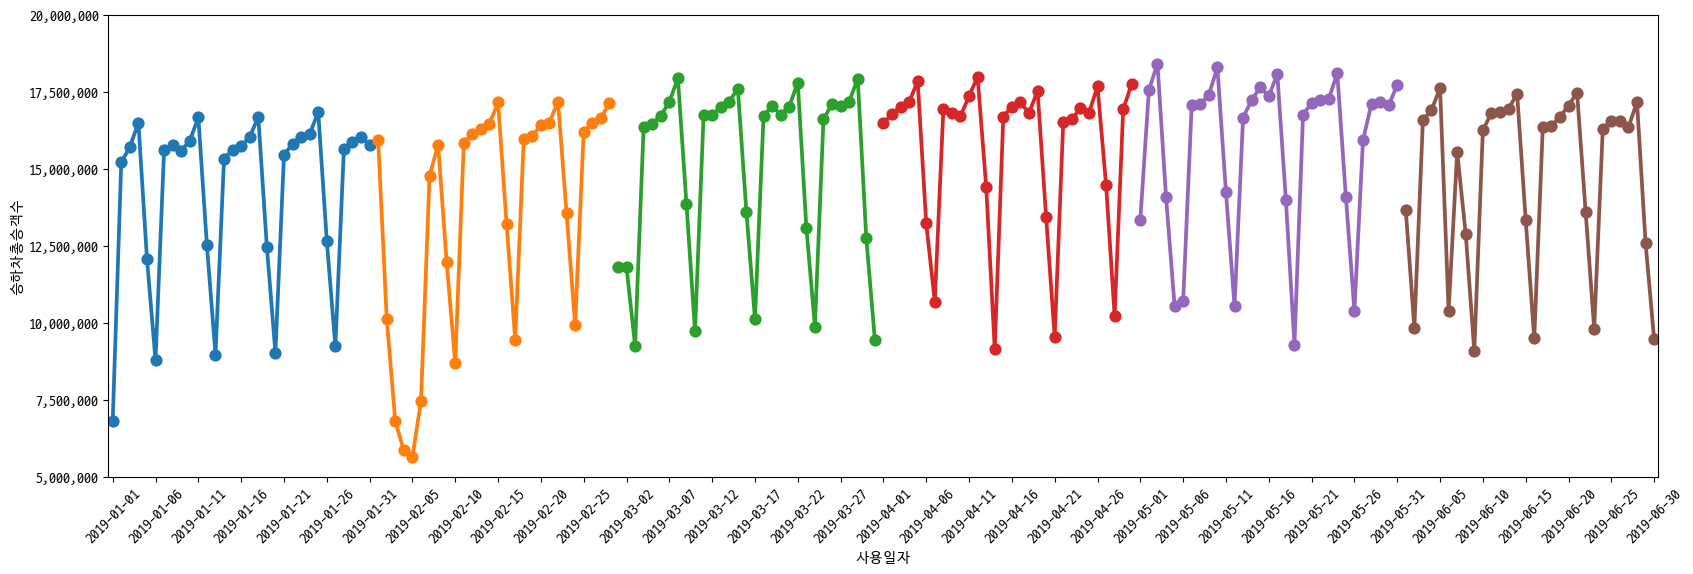

In [25]:
plt.figure(figsize=(20, 6))
for month in range(1, 6+1):
    sns.pointplot(data=df[df['월'] == month], x='사용일자', y='승하차총승객수')
plt.yticks(np.linspace(0.5e7, 2e7, 7), map(lambda x: f'{int(x):,}', np.linspace(0.5e7, 2e7, 7)))
plt.xticks(plt.xticks()[0][::5], rotation=45)
plt.show()

### 5. 가장 승객이 많이 타는 승차역은?

잠실역이 가장 많은 승객수 18,574,323명


,역명,승차총승객수,하차총승객수,등록일자,주차,연,월,승하차총승객수
413,잠실,"18,574,323.0","18,390,074.0",7308916248,4912,730878,1270,"36,964,397.0"


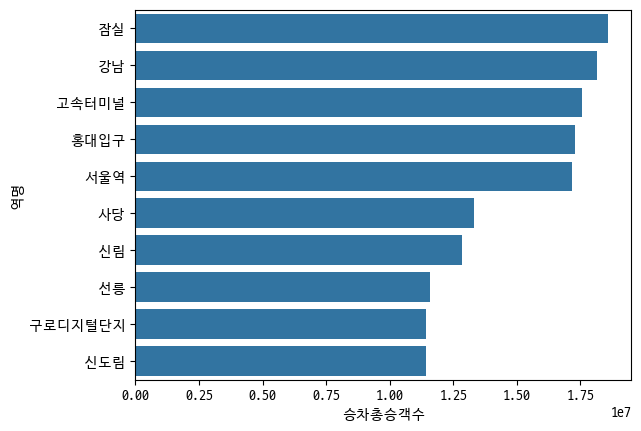

In [26]:
df = df_subway_raw.groupby('역명') \
    .sum('승차총승객수') \
    .reset_index() \
    .sort_values(by='승차총승객수', ascending=False)

row = df[['역명', '승차총승객수']].iloc[0]
print(f'{row["역명"]}역이 가장 많은 승객수 {row["승차총승객수"]:,.0f}명')

sns.barplot(data=df.head(10), x='승차총승객수', y='역명')

df.head(1)

### 6. 노선별로 역별/요일별 승차승객수를 비교해 볼수 있을까? (1~9호선, 역별/요일별 heatmap)

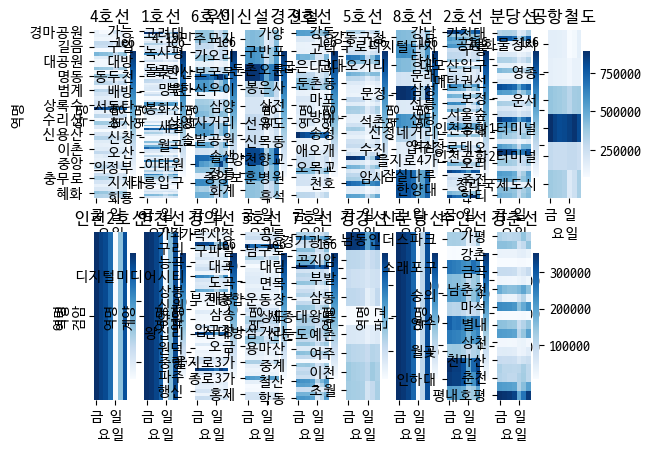

<Figure size 5000x1000 with 0 Axes>

In [27]:
n_lines = len(df_subway_raw['노선명'].unique())

SIZE = 5

W = 10
H = math.ceil(n_lines / W)

for line_no, line in enumerate(df_subway_raw['노선명'].unique()):
    df = df_subway_raw[df_subway_raw['노선명'] == line] \
        .groupby(['역명', '요일']) \
        .sum('승하차총승객수') \
        .reset_index() \
        .pivot(index='역명', columns='요일', values='승하차총승객수')

    plt.subplot(H, W, line_no+1)
    plt.title(line)
    sns.heatmap(data=df, fmt=',.0f', cmap='Blues')

plt.figure(figsize=(SIZE*W, SIZE*H))
plt.show()

### 7. 1호선에서 가장 하차를 많이 하는 역은? (groupby)

,역명,승차총승객수,하차총승객수,등록일자,주차,연,월,승하차총승객수
1,가산디지털단지,"10,111,317.0","10,571,381.0",7308916248,4912,730878,1270,"20,682,698.0"


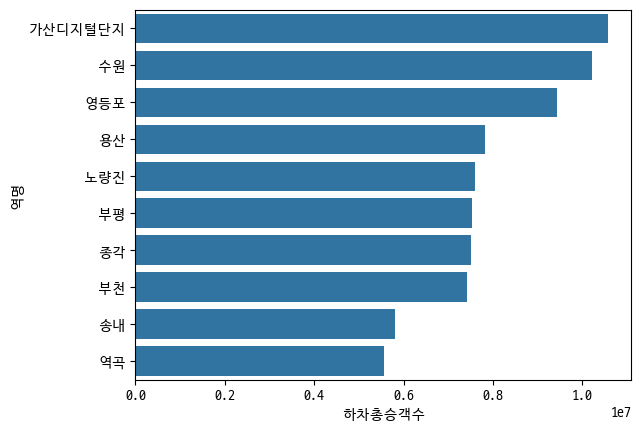

In [28]:
df = df_subway_raw[df_subway_raw['노선명'] == '1호선'] \
    .groupby('역명') \
    .sum('하차총승객수') \
    .reset_index() \
    .sort_values(by='하차총승객수', ascending=False)

sns.barplot(data=df.head(10), x='하차총승객수', y='역명')

df.head(1)

### 8. 2호선 중에서 어느 역에서 승차가 가장 많이 발생할까? (Folium 역 표시)

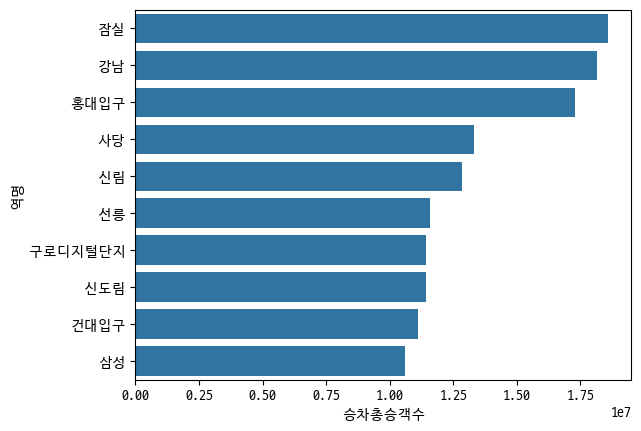

In [29]:
df = df_subway_raw[df_subway_raw['노선명'] == '2호선'] \
    .groupby('역명') \
    .sum('승차총승객수') \
    .reset_index() \
    .sort_values(by='승차총승객수', ascending=False)

sns.barplot(data=df.head(10), x='승차총승객수', y='역명')

target_station = df.iloc[0]['역명']

In [30]:
df = df_location_raw[df_location_raw['호선'] == '2호선'][df_location_raw['역이름'] == target_station]

foliun_map = folium.Map(location=[df['위도'], df['경도']], zoom_start=15)

folium.Marker(
    [df['위도'], df['경도']],
    popup=target_station,
).add_to(foliun_map)

foliun_map

/var/folders/ld/qthvz3k91_1239xs6fkx1zx00000gn/T/ipykernel_80461/2192961072.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_location_raw[df_location_raw['호선'] == '2호선'][df_location_raw['역이름'] == target_station]
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/venv/lib/python3.12/site-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/venv/lib/python3.12/site-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/venv/lib/python3.12/site-packages/folium/utilities.py:102: Future